In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, precision_recall_curve
import shap
import joblib
import os

pd.set_option("display.float_format", lambda x: f"{x:,.4f}")
sns.set(style="whitegrid", context="talk")

In [4]:
data_dir = "C://Users//aditi//OneDrive//Desktop//fraud_detection//processed"
model_dir = "C://Users//aditi//OneDrive//Desktop//fraud_detection//models"

X_test = pd.read_csv(f"{data_dir}/X_test.csv")
y_test = pd.read_csv(f"{data_dir}/y_test.csv").values.ravel()

lr_model = joblib.load(f"{model_dir}/logistic_model.pkl")
rf_model = joblib.load(f"{model_dir}/random_forest_model.pkl")
xgb_model = joblib.load(f"{model_dir}/xgboost_fraud_model.pkl")

X_test.shape, y_test.shape

((100, 17), (100,))

In [5]:
fraud_rate = y_test.mean()
fraud_rate

0.05

In [6]:
models = {
    "Logistic Regression": lr_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model
}

results = []

for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)
    
    results.append({
        "Model": name,
        "ROC-AUC": roc_auc_score(y_test, y_prob),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "Accuracy": accuracy_score(y_test, y_pred)
    })

comparison_df = pd.DataFrame(results)
comparison_df


,Model,ROC-AUC,Precision,Recall,F1-Score,Accuracy
0,Logistic Regression,0.4232,0.0513,0.4000,0.0909,0.6000
1,Random Forest,0.5074,0.0000,0.0000,0.0000,0.9400
2,XGBoost,0.4505,0.0000,0.0000,0.0000,0.9300


In [7]:
FP_COST = 10
FN_COST = 500

def business_cost(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp * FP_COST + fn * FN_COST


In [8]:
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]
default_preds = (xgb_probs >= 0.5).astype(int)

business_cost(y_test, default_preds)


2520

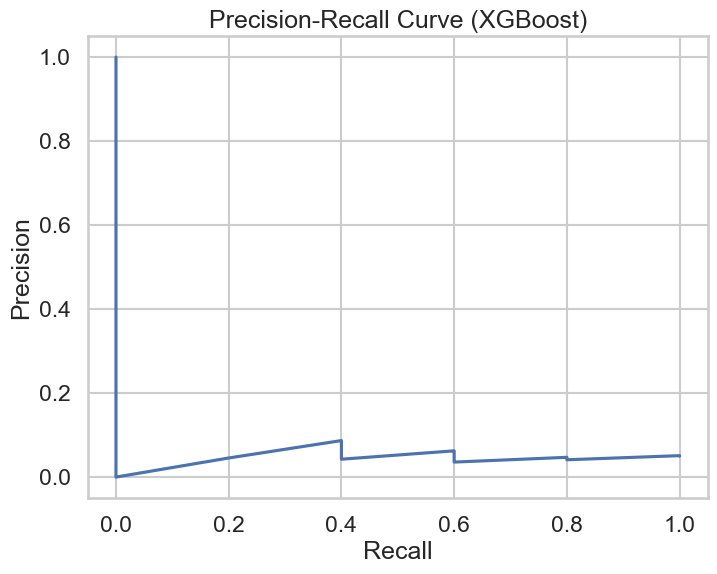

In [9]:
precision, recall, thresholds = precision_recall_curve(y_test, xgb_probs)

plt.figure(figsize=(8,6))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (XGBoost)")
plt.show()


In [10]:
threshold_costs = []

for t in thresholds:
    preds = (xgb_probs >= t).astype(int)
    cost = business_cost(y_test, preds)
    threshold_costs.append(cost)

optimal_idx = np.argmin(threshold_costs)
optimal_threshold = thresholds[optimal_idx]

optimal_threshold


0.0012812781

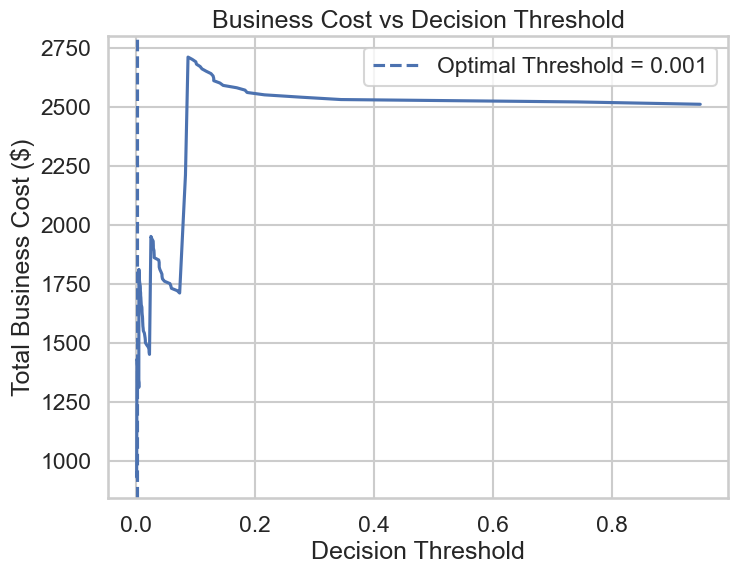

In [12]:
plt.figure(figsize=(8,6))
plt.plot(thresholds, threshold_costs)
plt.axvline(optimal_threshold, linestyle="--", label=f"Optimal Threshold = {optimal_threshold:.3f}")
plt.xlabel("Decision Threshold")
plt.ylabel("Total Business Cost ($)")
plt.title("Business Cost vs Decision Threshold")
plt.legend()
plt.show()


In [13]:
optimal_preds = (xgb_probs >= optimal_threshold).astype(int)
confusion_matrix(y_test, optimal_preds)


array([[ 2, 93],
       [ 0,  5]], dtype=int64)

In [14]:
with open(f"{model_dir}/final_threshold.txt", "w") as f:
    f.write(str(optimal_threshold))


In [15]:
model = xgb_model.named_steps["model"] if hasattr(xgb_model, "named_steps") else xgb_model
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)


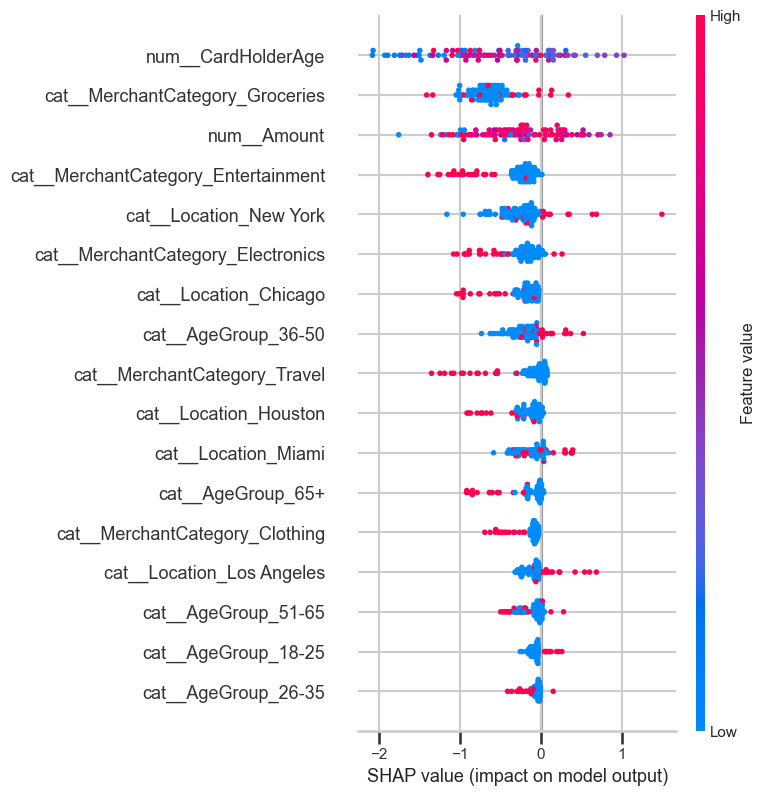

In [16]:
shap.summary_plot(shap_values, X_test, show=False)
plt.show()


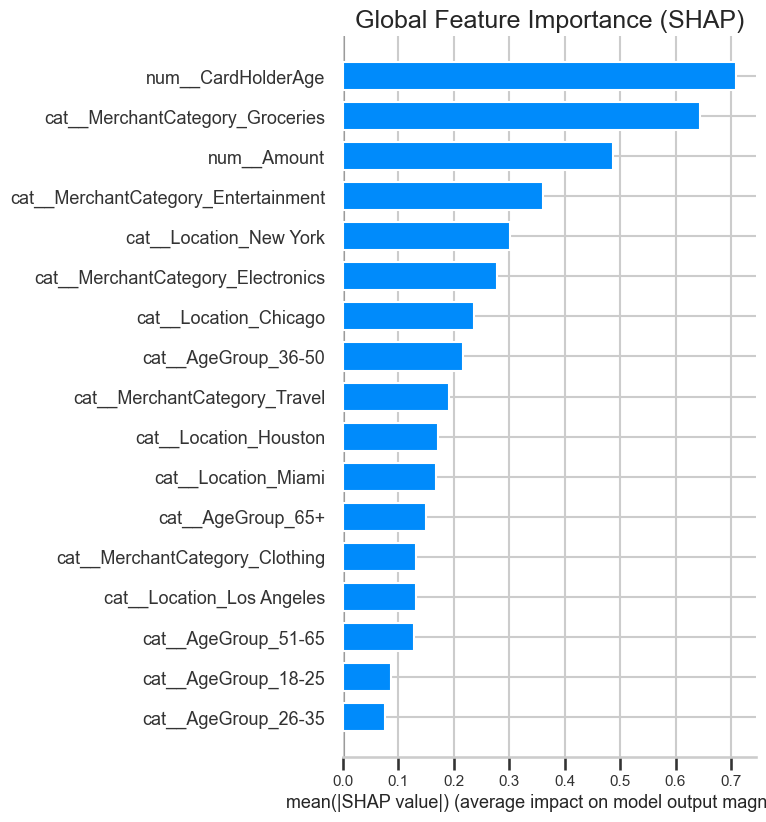

In [17]:
shap.summary_plot(
    shap_values,
    X_test,
    plot_type="bar",
    show=False
)
plt.title("Global Feature Importance (SHAP)")
plt.show()


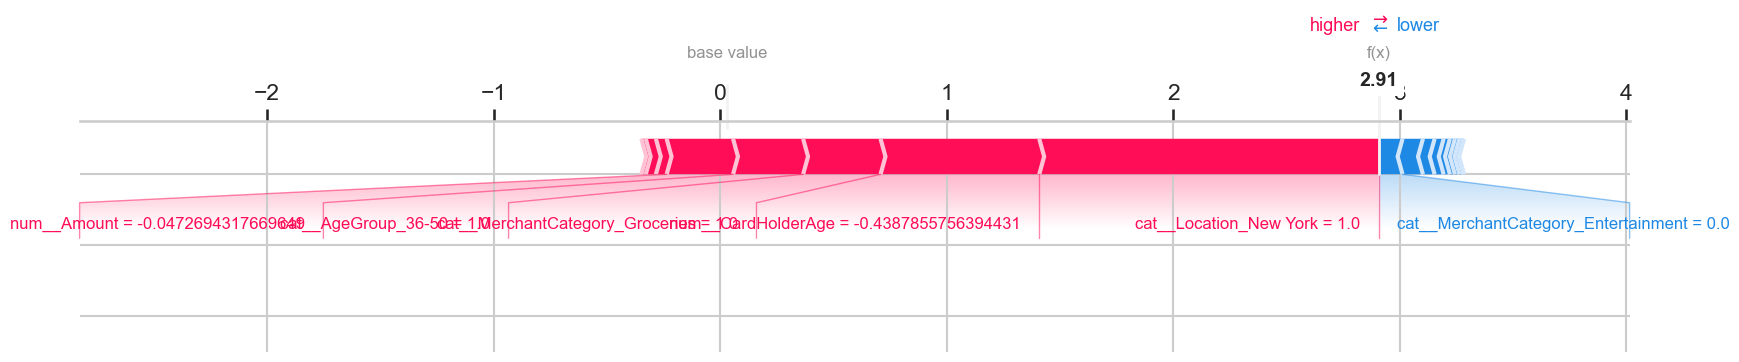

In [18]:
sample_idx = np.argmax(xgb_probs)

shap.force_plot(
    explainer.expected_value,
    shap_values[sample_idx],
    X_test.iloc[sample_idx],
    matplotlib=True
)
